In [1]:
#!pip install scikit-optimize --user --quiet
#!pip install apafib --upgrade --user --quiet
#!pip install ucimlrepo --upgrade  --quiet
#!pip install -U numpy scipy scikit-learn pandas matplotlib seaborn statsmodels yellowbrick

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier.rocauc import roc_auc

import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.naive_bayes import MultinomialNB

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
SEED = 3011
# Para reproducibilidad
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
def save_results(clf,  X_test, y_test, nclf, df):
    df.loc[nclf,'train XV acc'] = clf.best_score_
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

In [6]:
# Clase para generar un dataset a patir de las matrices de datos y etiquetas
class miniMNIST(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data).float()
        self.labels = torch.Tensor(labels).long()
        self.n_classes = len(np.unique(labels))

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, F.one_hot(y, self.n_classes).float()

    def __len__(self):
        return len(self.data)

# Generar el data loader
# MNIST = torch.utils.data.DataLoader(miniMNIST(train, labels), batch_size=32)

In [7]:
# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, patience=5, epochs=100):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenal
        train: datos de entrenamiento
        val: datos de validacion
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for i, (data, labels) in enumerate(dataset):
            inputs = data.to('cuda')
            y = labels.to('cuda')
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, y, reduction="mean")
            data_loss += loss.item()
        return data_loss / i

    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > val_loss[-(patience+1)]:
                return True

    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        for i, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to('cuda')
            y = labels.to('cuda')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = F.cross_entropy(outputs, y, reduction="mean")

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion

        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})
        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break
    return hist_loss

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun

In [8]:
# Clase para definir la arquitectura del MLP
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers_sizes, activation=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(input_size, hidden_layers_sizes[0])
        self.layers.append(self.fc1)
        self.layers.append(activation())
        for i in range(1, len(hidden_layers_sizes)):
            self.layers.append(nn.Linear(hidden_layers_sizes[i-1], hidden_layers_sizes[i]))
            self.layers.append(activation())
        self.layers = nn.Sequential(*self.layers)
        self.output = nn.Linear(hidden_layers_sizes[-1], num_classes)

    def forward(self, x):
        return self.output(self.layers(x))

    def get_features(self, x):  #Afegit per apartat e
        return self.layers(x)

In [9]:
def test_model(model, test):
    """_Funcion para obtener las predicciones de un modelo en un conjunto de test_

    Poner el modelo en modo evaluacion antes de llamar a esta funcion

    Args:
        model: _modelo entrenado_
        test: _conjunto de test_

    Returns:
        _type_: _etiquetas predichas, etiquetas reales_
    """
    preds = []
    true = []
    for i, (data, labels) in enumerate(test):
        inputs = data.to('cuda')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(labels.detach().cpu().numpy())
    return np.argmax(np.concatenate(preds), axis=1), np.argmax(np.concatenate(true), axis=1)

In [10]:
# Clase para definir la arquitectura de la red convolucional
class convolutional(nn.Module):
    def __init__(self, num_classes=5, kernels=[16,32], activation=nn.ReLU):
        super(convolutional, self).__init__()
        self.convo1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            activation(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convo2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            activation(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*kernels[1], num_classes)

    def forward(self, x):
        out = self.convo2(self.convo1(x.view(x.size(0), 1, 28, 28)))
        return self.fc(out.reshape(out.size(0), -1))

    def get_features(self, x):  #Afegit per apartat e
        out = self.convo2(self.convo1(x.view(x.size(0), 1, 28, 28)))
        return out.reshape(out.size(0), -1)



---

a)
Los datos corresponden a imágenes de 28 × 28 píxeles en niveles de gris. Estos ya están
convertidos a vectores y normalizados a la escala [0,1]. Aplicad PCA y t-SNE a los datos
de entrenamiento y represéntadlos en 2D. ¿Se puede ver separabilidad entre las clases?
Comentad el resultado.

In [11]:
from apafib import load_MNIST
data = load_MNIST(digits = (3,5,6,8,9), sel = 4)
X_train = data[0]
X_test = data[1]
y_train = data[2]
y_test = data[3]


In [12]:
X_train[0]
y_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

np.uint8(1)

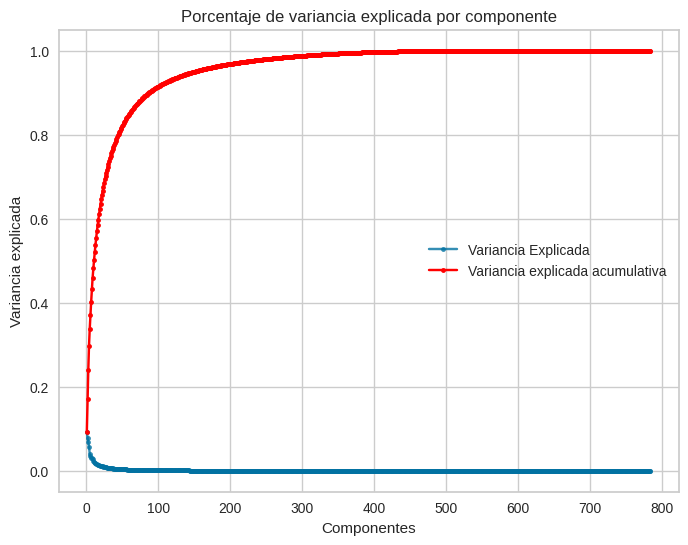

In [13]:
pca = PCA().fit(X_train)

fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente');

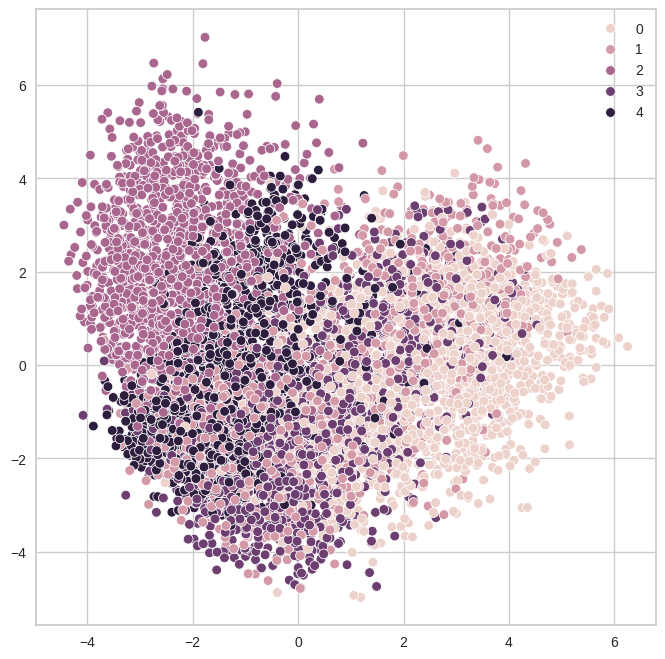

In [14]:
#PCA
X_trans = pca.transform(X_train)
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=y_train);

En esta representación del PCA, se observa que únicamente las clases 0 y 2 presentan una separación clara respecto al resto. Las demás clases aparecen muy solapadas y agrupadas en el centro del gráfico.

<Axes: >

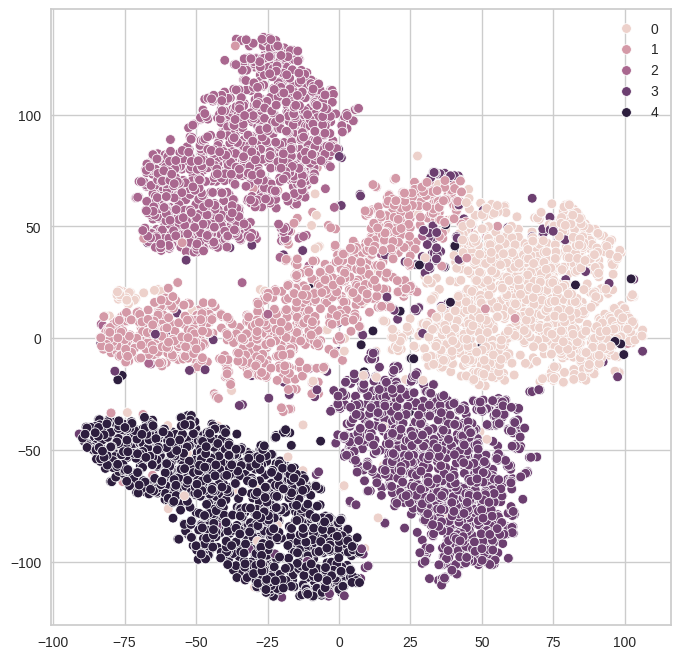

In [15]:
# t-SNE
X_trans = TSNE(n_components=2, perplexity=20, max_iter=2000, init='pca').fit_transform(X_train)
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=y_train)

A diferencia del PCA, el t-SNE si que muestra patrones más claros. Se pueden observar cinco grupos claramente diferenciados, aunque existen algunos puntos que se separan de sus clústers.

---

b)

Comenzaremos por obtener un valor de acierto base.

Asumiendo que los píxeles son independientes y se distribuyen de manera Multinomial (solo hay 16 valores distintos en
los datos).

Ajustad un modelo Naïve Bayes Multinomial. Evaluad la calidad del modelo y
comentad los resultados.

In [16]:
print('Multinomial Naïve Bayes')
mnb = MultinomialNB()
mnb.best_score_ = np.mean(cross_val_score(mnb,X_train,y_train,cv=10,scoring="accuracy"))
print('accuracy:',mnb.best_score_)

cls = ['0','1','2','3','4']

mnb_model = MultinomialNB().fit(X_train, y_train)
mnb_model.best_score_ = mnb.best_score_

Multinomial Naïve Bayes
accuracy: 0.8576168210326449


En rendimineto general el modelo obtiene un accuracy del 0.857. El modelo obtiene un rendimiento moderadamente bueno como modelo base, superando ampliamente el azar (20% para 5 clases).

In [17]:
print(classification_report(y_test, mnb_model.predict(X_test), target_names=['0', '1','2','3','4']))
results_df = save_results(mnb_model, X_test, y_test, 'MNB', results_df)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       266
           1       0.85      0.68      0.76       235
           2       0.95      0.92      0.93       224
           3       0.77      0.86      0.81       228
           4       0.88      0.96      0.91       258

    accuracy                           0.86      1211
   macro avg       0.86      0.86      0.86      1211
weighted avg       0.86      0.86      0.86      1211



Si miramos en detalle cada clase podemos ver que donde mejor rendimiento tenemos es en la calse 2 donde tenemos un F1-score del 0.93 (precision 0.95, reall 0.92), con una excelente separabilidad. Tambien descatar la clase 4 con un F1-score del 0.91 (precision 0.88, recall 0.96) esta tiene muy buen rendimiento.
Las clases con peor rendimiento son la 1 y la 3, con F1-scores de 0.76 y 0.81 respectivament (clase 1: precision 0.85, recall 0.68 y clase 3: precision 0.77, recall 0.86).

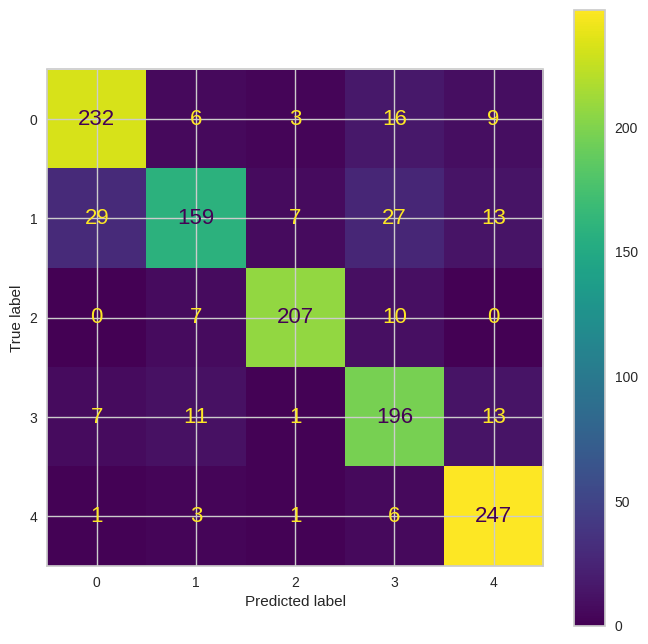

In [18]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mnb_model, X_test,y_test, display_labels=['0', '1','2','3','4'], ax=plt.subplot());

Aquí podemos ver que la clase 1 es confundida principalmente con la clase 0 y 3 (29 y 27 casos respectivamente) y la clase 3 es confundida principalmente con la clase 1 y 4 (11 y 13 casos respectivamente). Tambien podemos observar que como deciamos, la classe con mejor rendimiento es la 2.

<Figure size 800x800 with 0 Axes>

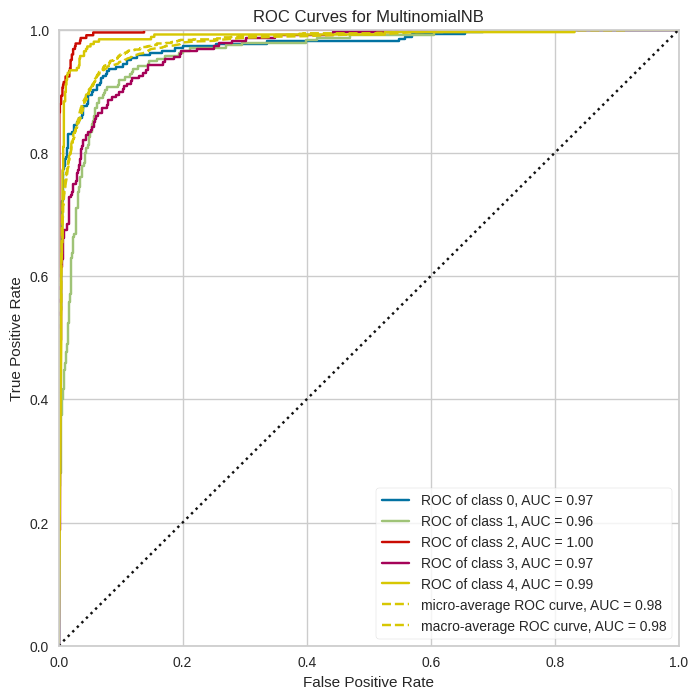

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['0', '1', '2', '3', '4'], estimator=MultinomialNB())

In [19]:
plt.figure(figsize=(8,8));
roc_auc(mnb_model, X_train, y_train, X_test, y_test, classes=cls)

En las curvas ROC podemos ver que el AUC es excelente ya que ronda 0.96-1.0 en todas las clases, esto indica que el modelo tiene una capacidad de discriminación muy buena entre clases. A lo que podemos añadir que todas las clases muestran una curva ROC muy por encima de la diagonal, casi llegando a la esquina superior izquierda, lo que indica un rendimiento excelente del modelo en términos de sensibilidad y especificidad.

La suposición de independencia entre píxeles es claramente violada en imágenes, donde píxeles adyacentes están correlacionados. A pesar de esto, el modelo logra un rendimiento razonable, estableciendo un baseline sólido para comparar con modelos más sofisticados como el MLP.



---

c)

Ahora aplicaremos un MLP a estos datos. En el código del notebook tenéis una función
que permite generar modelos MLP variando el número de capas y la función de activación.

La red se define como una clase python donde en el método __init__ definimos los
elementos de la red y en el forward cómo se hace la propagación hacia adelante en la red
(la propagación hacia atrás se calcula automáticamente).


Para pasarle los datos a un modelo de torch hay que definir una clase del tipo Dataset,
tenéis una ya definida en el notebook a la que hay que pasarle la matriz de datos y el vector
con las etiquetas. Esta clase se ha de pasar a un objeto Dataloader que se encarga de
organizar el uso de los datos durante el entrenamiento, entre otras cosas de partir los datos
en grupos (batch_size), podéis ver un ejemplo en el notebook.
Tendréis que separar una
parte de datos de entrenamiento para validación (10 %), ya que no usaremos validación
cruzada.

Para entrenar los modelos usaremos la función train_loop que tenéis en el notebook. Esta
función recibe el modelo, el optimizador a usar, los datos de entrenamiento y validación y
el número de iteraciones que hará el entrenamiento.

Para el optimizador usaremos adam,
podéis ver en el notebook como generar el objeto del optimizador.

Entrenad diferentes redes de 2 y 3 capas con diferentes tamaños usando como función de
activación ReLU y Sigmoid. Para los tamaños podéis elegir el tamaño de la primera capa
oculta y después ir reduciéndolo a la mitad para las capas sucesivas. Para crear la red solo
tenéis que crear un objeto de la clase MLP pasándole los parámetros adecuados. Al generar
el objeto tendréis que subir el modelo a la GPU usando el método modelo.to(’cuda’) (si
no lo hacéis torch se quejará de que los datos y el modelo no están en el mismo dispositivo).
Veréis que la función de entrenamiento retorna la historia de la función de pérdida para el
entrenamiento y validación. Usad esta información para comprobar el número de épocas
que realmente se necesita para converger. Podéis comprobar si la red ha sobre especializado
con el conjunto de test.
Evaluad los resultados. Para ello podéis usar la función test_model que tenéis en el note-
book. Se le ha de pasar el modelo entrenado y un conjunto de datos y retornará las etiquetas
de las predicciones y las reales, a partir de ahí podéis usar las funciones de scikit learn
para obtener las medidas de evaluación.

In [20]:
# 1) Dataset completo de entrenamiento
from torch.utils.data import random_split
train_full = miniMNIST(X_train, y_train)

# 2) Split en train (90%) y val (10%)
val_ratio = 0.1
n_total = len(train_full)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
generator1 = torch.Generator().manual_seed(3011)
train_dataset, val_dataset = random_split(train_full, [n_train, n_val], generator=generator1)

# 3) DataLoaders
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# Loader para extracción (orden fijo)
extract_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #Nou
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# 4) DataLoader de test
test_dataset = miniMNIST(X_test, y_test)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
input_size  = X_train.shape[1]
num_classes = len(np.unique(y_train))

configs = {
    # 2 capas ocultas - ReLU
    "2layers_relu_256": {
        "hidden_layers": [256, 128],
        "activation": nn.ReLU
    },
    "2layers_relu_128": {
        "hidden_layers": [128, 64],
        "activation": nn.ReLU
    },

    # 2 capas ocultas - Sigmoid
    "2layers_sigmoid_256": {
        "hidden_layers": [256, 128],
        "activation": nn.Sigmoid
    },
    "2layers_sigmoid_128": {
        "hidden_layers": [128, 64],
        "activation": nn.Sigmoid
    },

    # 3 capas ocultas - ReLU
    "3layers_relu_256": {
        "hidden_layers": [256, 128, 64],
        "activation": nn.ReLU
    },
    "3layers_relu_128": {
        "hidden_layers": [128, 64, 32],
        "activation": nn.ReLU
    },

    # 3 capas ocultas - Sigmoid
    "3layers_sigmoid_256": {
        "hidden_layers": [256, 128, 64],
        "activation": nn.Sigmoid
    },
    "3layers_sigmoid_128": {
        "hidden_layers": [128, 64, 32],
        "activation": nn.Sigmoid
    },
}

In [22]:
results_mlp = {}

for name, cfg in configs.items():
    print(f"\nEntrenando modelo: {name}")

    # Crear modelo
    model = MLP(
        input_size=input_size,
        num_classes=num_classes,
        hidden_layers_sizes=cfg["hidden_layers"],
        activation=cfg["activation"]
    ).to("cuda")

    # Optimizador Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Entrenamiento
    hist_loss = train_loop(
        model=model,
        train=train_loader,
        val=val_loader,
        optimizer=optimizer,
        patience=5,     # early stopping
        epochs=100
    )

    # Evaluación en test
    model.eval()
    with torch.no_grad():
        y_pred, y_true = test_model(model, test_loader)

    acc = accuracy_score(y_true, y_pred)

    print(f"Accuracy en test ({name}): {acc:.4f}")

    # Guardamos todo por si luego quieres analizar/plotear
    results_mlp[name] = {
        "model": model,
        "hist_loss": hist_loss,
        "y_pred": y_pred,
        "y_true": y_true,
        "accuracy": acc
    }



Entrenando modelo: 2layers_relu_256


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=128, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_256): 0.9637

Entrenando modelo: 2layers_relu_128


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_128): 0.9562

Entrenando modelo: 2layers_sigmoid_256


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=128, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_256): 0.9505

Entrenando modelo: 2layers_sigmoid_128


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_128): 0.9480

Entrenando modelo: 3layers_relu_256


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
)

Accuracy en test (3layers_relu_256): 0.9604

Entrenando modelo: 3layers_relu_128


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (output): Linear(in_features=32, out_features=5, bias=True)
)

Accuracy en test (3layers_relu_128): 0.9579

Entrenando modelo: 3layers_sigmoid_256


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
)

Accuracy en test (3layers_sigmoid_256): 0.9488

Entrenando modelo: 3layers_sigmoid_128


  0%|          | 0/100 [00:00<?, ?it/s]

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
  )
  (output): Linear(in_features=32, out_features=5, bias=True)
)

Accuracy en test (3layers_sigmoid_128): 0.9505


Despues de entrenar todas las combinaciones podemos ver que el MLP `2layers_relu_256` alcanza un **accuracy de 96.37%**, lo que representa una **mejora significativa de ~11 puntos porcentuales** respecto al Naive Bayes Multinomial (85.8%). Esto confirma que el MLP captura mejor las dependencias espaciales entre píxeles.

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

name = "2layers_relu_256"   # poner el nombre del modelo a analizar
y_true = results_mlp[name]["y_true"]
y_pred = results_mlp[name]["y_pred"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:\n")
print(classification_report(y_true, y_pred))

Accuracy: 0.9636663914120561

Classification report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       266
           1       0.95      0.95      0.95       235
           2       0.97      0.96      0.96       224
           3       0.97      0.95      0.96       228
           4       0.97      0.98      0.98       258

    accuracy                           0.96      1211
   macro avg       0.96      0.96      0.96      1211
weighted avg       0.96      0.96      0.96      1211



Todas las clases muestran F1-scores excelentes (0.95-0.98):

- **Clase 4**: Mejor rendimiento (F1=0.98, precision=0.97, recall=0.98)
- **Clases 0 y 2**: Excelente separabilidad (F1=0.97 y 0.96 respectivamente)
- **Clases 1 y 3**: Mejora sustancial respecto a MNB (F1=0.95-0.96 vs 0.76-0.81)

<Figure size 800x800 with 0 Axes>

Text(0.5, 1.0, 'Matriz de confusión - MLP')

<Figure size 800x800 with 0 Axes>

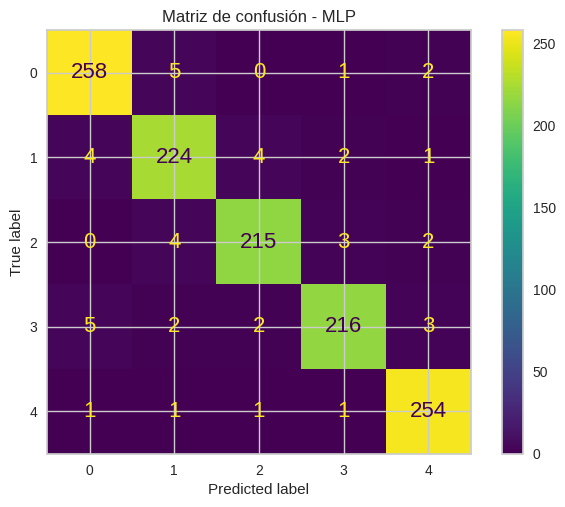

In [24]:
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=['0', '1', '2', '3', '4'],  # o las que toquen
)
plt.title("Matriz de confusión - MLP")
plt.show()

La diagonal dominante indica una clasificación muy precisa. Las confusiones residuales son mínimas:
- Apenas 12-19 errores por clase en un total de ~230-260 muestras
- La clase 1 (que era problemática en MNB) ahora tiene solo 12 errores vs 75 anteriormente

**Comparación con Naïve Bayes Multinomial**

| Métrica | MNB | MLP | Mejora |
|---------|-----|-----|--------|
| Accuracy | 85.8% | 96.3% | +9.0% |
| F1-score (clase 1) | 0.76 | 0.95 | +25% |
| F1-score (clase 3) | 0.81 | 0.96 | +18% |

El modelo MLP demuestra una **superioridad clara** sobre el baseline Naïve Bayes, logrando un accuracy del 96.3% (mejora de +11 puntos porcentuales). Esta mejora es particularmente notable en las clases problemáticas: la clase 1 pasa de F1=0.76 a 0.95 (+25%), y la clase 3 de 0.81 a 0.96 (+18%). El MLP captura efectivamente las dependencias espaciales entre píxeles que el modelo Naïve Bayes ignora por su suposición de independencia, resultando en una clasificación mucho más robusta con confusiones mínimas (apenas 12-19 errores por clase). La arquitectura relativamente simple de 2 capas con ReLU (`2layers_relu_256`) ya proporciona resultados excelentes, validando el uso de redes neuronales para este problema de clasificación de imágenes.

---

d)

Las redes MLP tienen bastantes parámetros y son menos eficientes que las redes convolucionales en tareas de imágenes. Tenéis en el notebook una clase que permite definir redes
convolucionales para los datos del problema. Entrenad redes de dos capas que tengan diferentes números de kernels convolucionales, para ello, elegid el número de kernels para
la primera capa y dobladlo para la segunda. Podéis evaluar el modelo de la misma manera
que en el apartado anterior. Comparad los resultados.

In [25]:
input_size  = X_train.shape[1]
num_classes = len(np.unique(y_train))

configs = {
    # 2 capas ocultas - ReLU
    "2layers_relu_16": {
        "kernels": [16, 32],
        "activation": nn.ReLU
    },
    "2layers_relu_32": {
        "kernels": [32, 64],
        "activation": nn.ReLU
    },
    "2layers_relu_64": {
        "kernels": [64, 128],
        "activation": nn.ReLU
    },
    "2layers_relu_128": {
        "kernels": [128, 256],
        "activation": nn.ReLU
    },
    "2layers_relu_256": {
        "kernels": [256, 512],
        "activation": nn.ReLU
    },

    # 2 capas ocultas - Sigmoid
    "2layers_sigmoid_16": {
        "kernels": [16, 32],
        "activation": nn.Sigmoid
    },
    "2layers_sigmoid_32": {
        "kernels": [32, 64],
        "activation": nn.Sigmoid
    },
    "2layers_sigmoid_64": {
        "kernels": [64, 128],
        "activation": nn.Sigmoid
    },
    "2layers_sigmoid_128": {
        "kernels": [128, 256],
        "activation": nn.Sigmoid
    },
    "2layers_sigmoid_256": {
        "kernels": [256, 512],
        "activation": nn.Sigmoid
    },
}

In [26]:
results_cnn = {}

for name, cfg in configs.items():
    print(f"\nEntrenando modelo: {name}")

    # Crear modelo
    model = convolutional(
        kernels=cfg["kernels"],
        activation=cfg["activation"]
    ).to("cuda")

    # Optimizador Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Entrenamiento
    hist_loss = train_loop(
        model=model,
        train=train_loader,
        val=val_loader,
        optimizer=optimizer,
        patience=5,     # early stopping
        epochs=100
    )

    # Evaluación en test
    model.eval()
    with torch.no_grad():
        y_pred, y_true = test_model(model, test_loader)

    acc = accuracy_score(y_true, y_pred)

    print(f"Accuracy en test ({name}): {acc:.4f}")

    # Guardamos todo por si luego quieres analizar/plotear
    results_cnn[name] = {
        "model": model,
        "hist_loss": hist_loss,
        "y_pred": y_pred,
        "y_true": y_true,
        "accuracy": acc
    }


Entrenando modelo: 2layers_relu_16


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_16): 0.9868

Entrenando modelo: 2layers_relu_32


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_32): 0.9835

Entrenando modelo: 2layers_relu_64


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_64): 0.9868

Entrenando modelo: 2layers_relu_128


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=12544, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_128): 0.9893

Entrenando modelo: 2layers_relu_256


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=25088, out_features=5, bias=True)
)

Accuracy en test (2layers_relu_256): 0.9909

Entrenando modelo: 2layers_sigmoid_16


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_16): 0.9860

Entrenando modelo: 2layers_sigmoid_32


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_32): 0.9884

Entrenando modelo: 2layers_sigmoid_64


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_64): 0.9901

Entrenando modelo: 2layers_sigmoid_128


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=12544, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_128): 0.9860

Entrenando modelo: 2layers_sigmoid_256


  0%|          | 0/100 [00:00<?, ?it/s]

convolutional(
  (convo1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=25088, out_features=5, bias=True)
)

Accuracy en test (2layers_sigmoid_256): 0.9876


Despues de entrenar todas las combinaciones podemos ver que la red convolucional `2layers_relu_256` alcanza un **accuracy de 99%**, lo que representa una **mejora significativa de ~14 puntos porcentuales** respecto al Naive Bayes Multinomial (85.8%) y una **mejora significativa de ~5 puntos porcentuales** respecto al MLP (94.8%). Esto confirma que la red convolucional es más eficiente que las redes MLP, capturando mejor las dependencias espaciales entre píxeles.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

name = "2layers_relu_256"   # el que tú quieras
y_true = results_cnn[name]["y_true"]
y_pred = results_cnn[name]["y_pred"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:\n")
print(classification_report(y_true, y_pred))

Accuracy: 0.990916597853014

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       266
           1       0.98      1.00      0.99       235
           2       0.99      1.00      0.99       224
           3       1.00      0.98      0.99       228
           4       0.99      0.99      0.99       258

    accuracy                           0.99      1211
   macro avg       0.99      0.99      0.99      1211
weighted avg       0.99      0.99      0.99      1211



Todas las clases muestran F1-scores casi perfectos (0.99), recalls casi perfectos (0.98-1) y precisiones casi perfectas también (0.98-1). Todas las clases tienen rendimientos casi perfectos y muy similares entre sí.

<Figure size 800x800 with 0 Axes>

Text(0.5, 1.0, 'Matriz de confusión - Red Convolucional')

<Figure size 800x800 with 0 Axes>

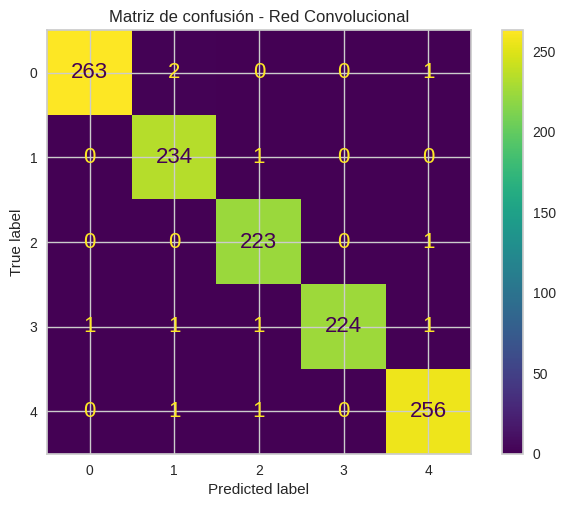

In [28]:
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=['0', '1', '2', '3', '4'],  # o las que toquen
)
plt.title("Matriz de confusión - Red Convolucional")
plt.show()

La diagonal dominante indica una clasificación muy precisa (casi perfecta). Las confusiones residuales son mínimas:
- No más de 5 errores por clase en un total de ~230-260 muestras

**Comparación con Naïve Bayes Multinomial y MLP**

| Métrica           | MNB   | MLP    | Red Convolucional | Mejora respecto MNB | Mejora respecto MLP|
|---------           |-----|-----|-------------------|---------------------|------------|
| Accuracy           | 85.8% | 96.3% | 99% | +14.2% | +2.7% |
| F1-score (clase 0) | 0.87 | 0.93   | 0.99 | +14% | +6.5% |
| F1-score (clase 1) | 0.76 | 0.93   | 0.99 | +30% | +6.5% |
| F1-score (clase 2) | 0.93 | 0.93   | 0.99 | +6.5% | +6.5% |
| F1-score (clase 3) | 0.81 | 0.94   | 0.99 | +22% | +5.3% |
| F1-score (clase 4) | 0.91 | 0.93   | 0.99 | +8.8% | +6.5% |

La red concolucional demuestra una **superioridad clara** sobre el baseline Naïve Bayes y sobre el modelo MLP, logrando un accuracy del 99% (mejora de +14 y +5 puntos porcentuales respectivamente). La red convolucional captura efectivamente las dependencias espaciales entre píxeles que el modelo Naïve Bayes ignora por su suposición de independencia, y lo hace mejor que el modelo MLP, resultando en una clasificación mucho más robusta y consistente con confusiones mínimas (menos de 5 errores por clase). La arquitectura relativamente simple de 2 capas con ReLU (`2layers_relu_256`) proporciona resultados excelentes, validando el uso de redes convolucionales para este problema de clasificación de imágenes.

e)

Podemos visualizar el efecto tiene la función aprendida por las redes obteniendo el resultado antes de la capa de salida (la capa lineal final). Añadid un método a las clases que definen las redes que apliquen a la entrada las capas de la red excepto esa última capa.  
Obtened el resultado de esta transformación a partir de las mejores redes entrenadas para el MLP y para la convoluciona con ReLU y sigmoide. Aplicad un PCA a ese resultado y visualizadlo. Comentad los resultados.

In [29]:
def extract_features(model, dataloader, device='cuda'):
    """Extrae las features antes de la capa final"""
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            inputs = data.to(device)
            feat = model.get_features(inputs)
            features.append(feat.cpu().numpy())
            # Convertir one-hot a etiquetas
            labels.append(torch.argmax(label, dim=1).numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [30]:
# MLP
mlp_relu_model = results_mlp["2layers_relu_256"]["model"]
features_mlp_relu, labels_mlp_relu = extract_features(mlp_relu_model, extract_loader)

mlp_sigmoid_model = results_mlp["2layers_sigmoid_128"]["model"]
features_mlp_sigmoid, labels_mlp_sigmoid = extract_features(mlp_sigmoid_model, extract_loader)

# CNN
cnn_relu_model = results_cnn["2layers_relu_256"]["model"]
features_cnn_relu, labels_cnn_relu = extract_features(cnn_relu_model, extract_loader)

cnn_sigmoid_model = results_cnn["2layers_sigmoid_32"]["model"]
features_cnn_sigmoid, labels_cnn_sigmoid = extract_features(cnn_sigmoid_model, extract_loader)

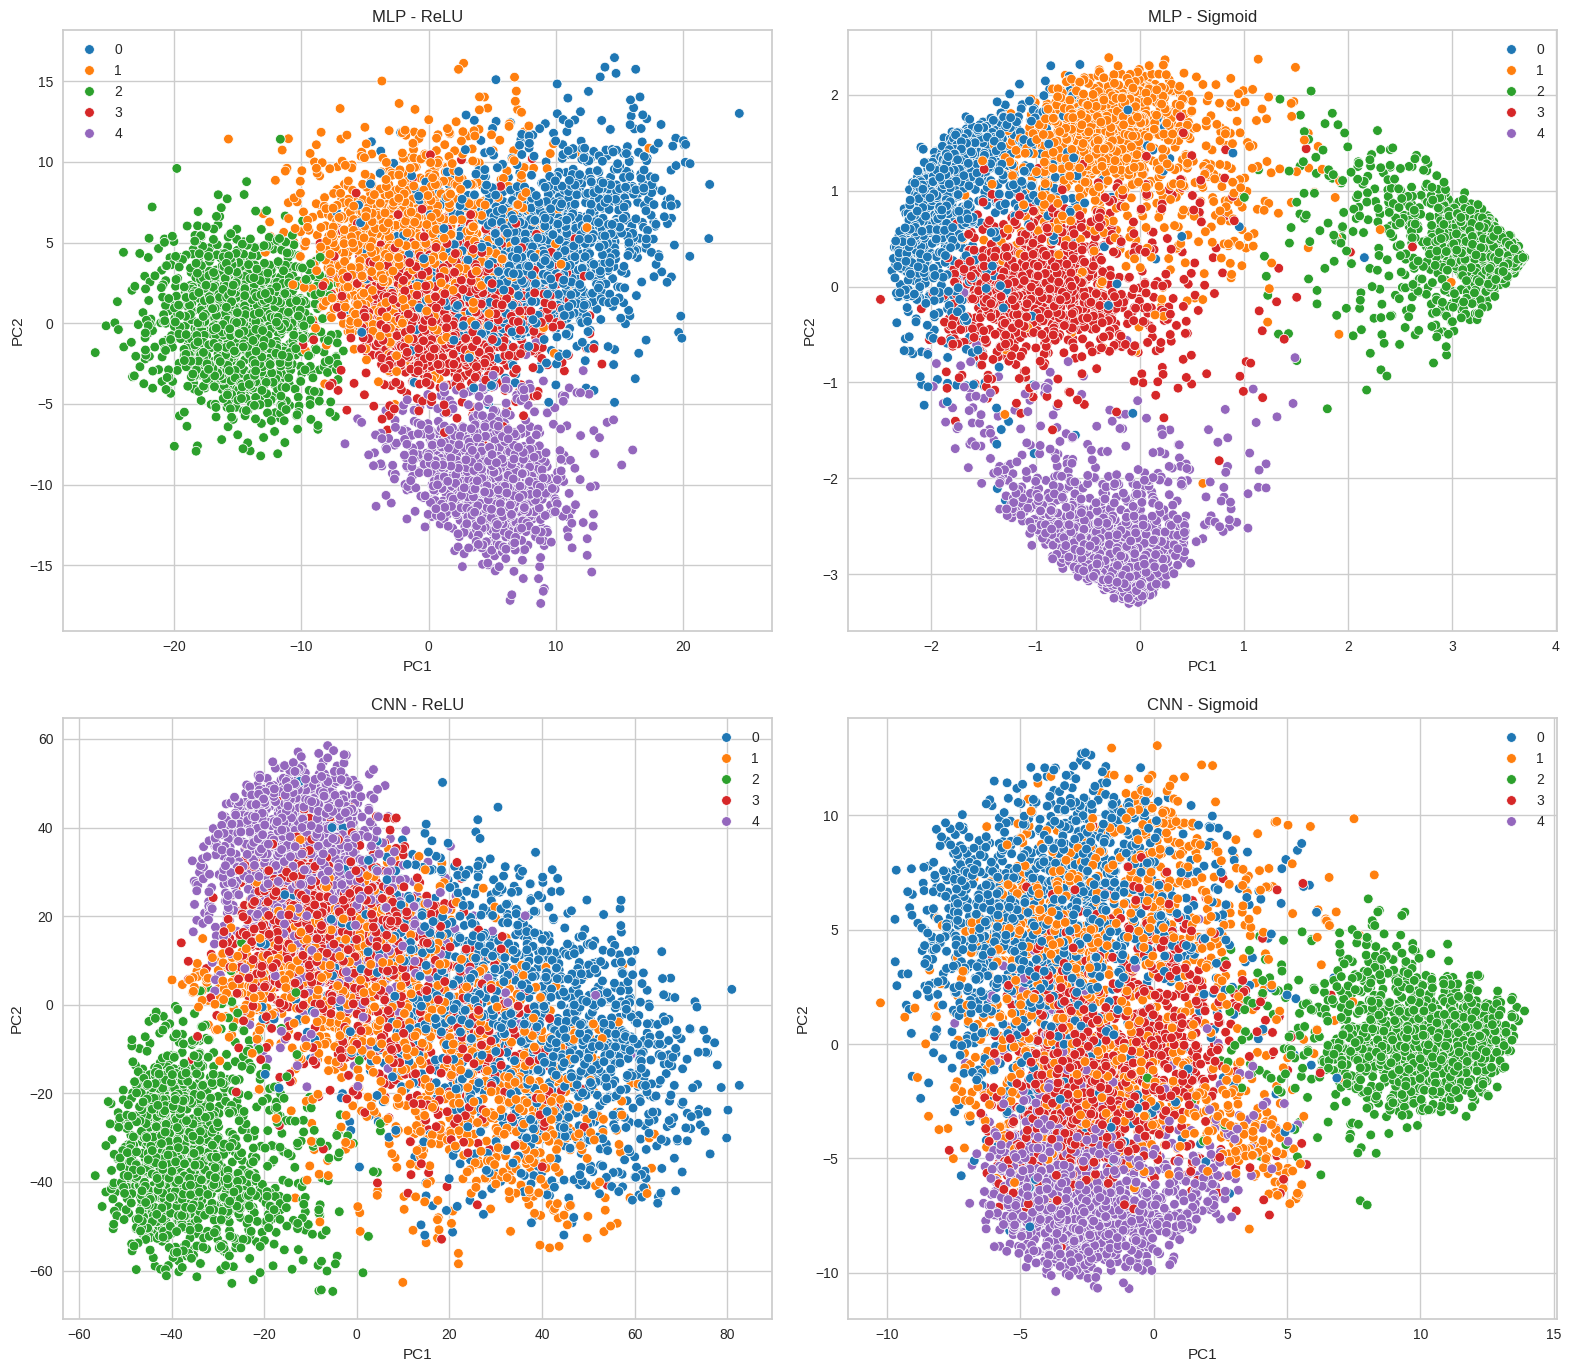

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# MLP ReLU
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_mlp_relu)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1],
                hue=labels_mlp_relu, ax=axes[0, 0], palette='tab10')
axes[0, 0].set_title('MLP - ReLU')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

# MLP Sigmoid
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_mlp_sigmoid)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1],
                hue=labels_mlp_sigmoid, ax=axes[0, 1], palette='tab10')
axes[0, 1].set_title('MLP - Sigmoid')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')

# CNN ReLU
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_cnn_relu)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1],
                hue=labels_cnn_relu, ax=axes[1, 0], palette='tab10')
axes[1, 0].set_title('CNN - ReLU')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

# CNN Sigmoid
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_cnn_sigmoid)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1],
                hue=labels_cnn_sigmoid, ax=axes[1, 1], palette='tab10')
axes[1, 1].set_title('CNN - Sigmoid')
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')

plt.tight_layout();
plt.show();

Los quatros PCA nos muestran unos patrones claros que no veiamos en el PCA inicial.

Podemos ver que en el de MLP con ReLU se pueden ver las classes 0, 2, 4 separadas, mientras que hay un solapamiento claro entre las classes 1 y 3.

Respecto el MLP con Sigmoid se ve un patron un poco mejor que el anterior, se ven igualmente los grupos 2 y 4 claramente diferenciados, en cambio, el el grupo 3 solapa con el 0 y el 1.

Seguimos con CNN con ReLU a ver, ya aprovechando comentamos tambien CNN con Sigmoid que se ven practicamente igual. De estas dos representaciones solo se ve clara la clase 2, y apurando la 4 (a grandes trechos), todas las otras classes nos muestran una nube densa en el centro donde no nos permite distingir una separibilidad clara.

Vamos a ver si en 3 dimensiones se ve alguna separabilidad más clara.


Text(0.5, 0.92, 'MLP - ReLU (3D)')

Text(0.5, 0, 'PC1')

Text(0.5, 0.5, 'PC2')

Text(0.5, 0, 'PC3')

Text(0.5, 0.92, 'MLP - Sigmoid (3D)')

Text(0.5, 0, 'PC1')

Text(0.5, 0.5, 'PC2')

Text(0.5, 0, 'PC3')

Text(0.5, 0.92, 'CNN - ReLU (3D)')

Text(0.5, 0, 'PC1')

Text(0.5, 0.5, 'PC2')

Text(0.5, 0, 'PC3')

Text(0.5, 0.92, 'CNN - Sigmoid (3D)')

Text(0.5, 0, 'PC1')

Text(0.5, 0.5, 'PC2')

Text(0.5, 0, 'PC3')

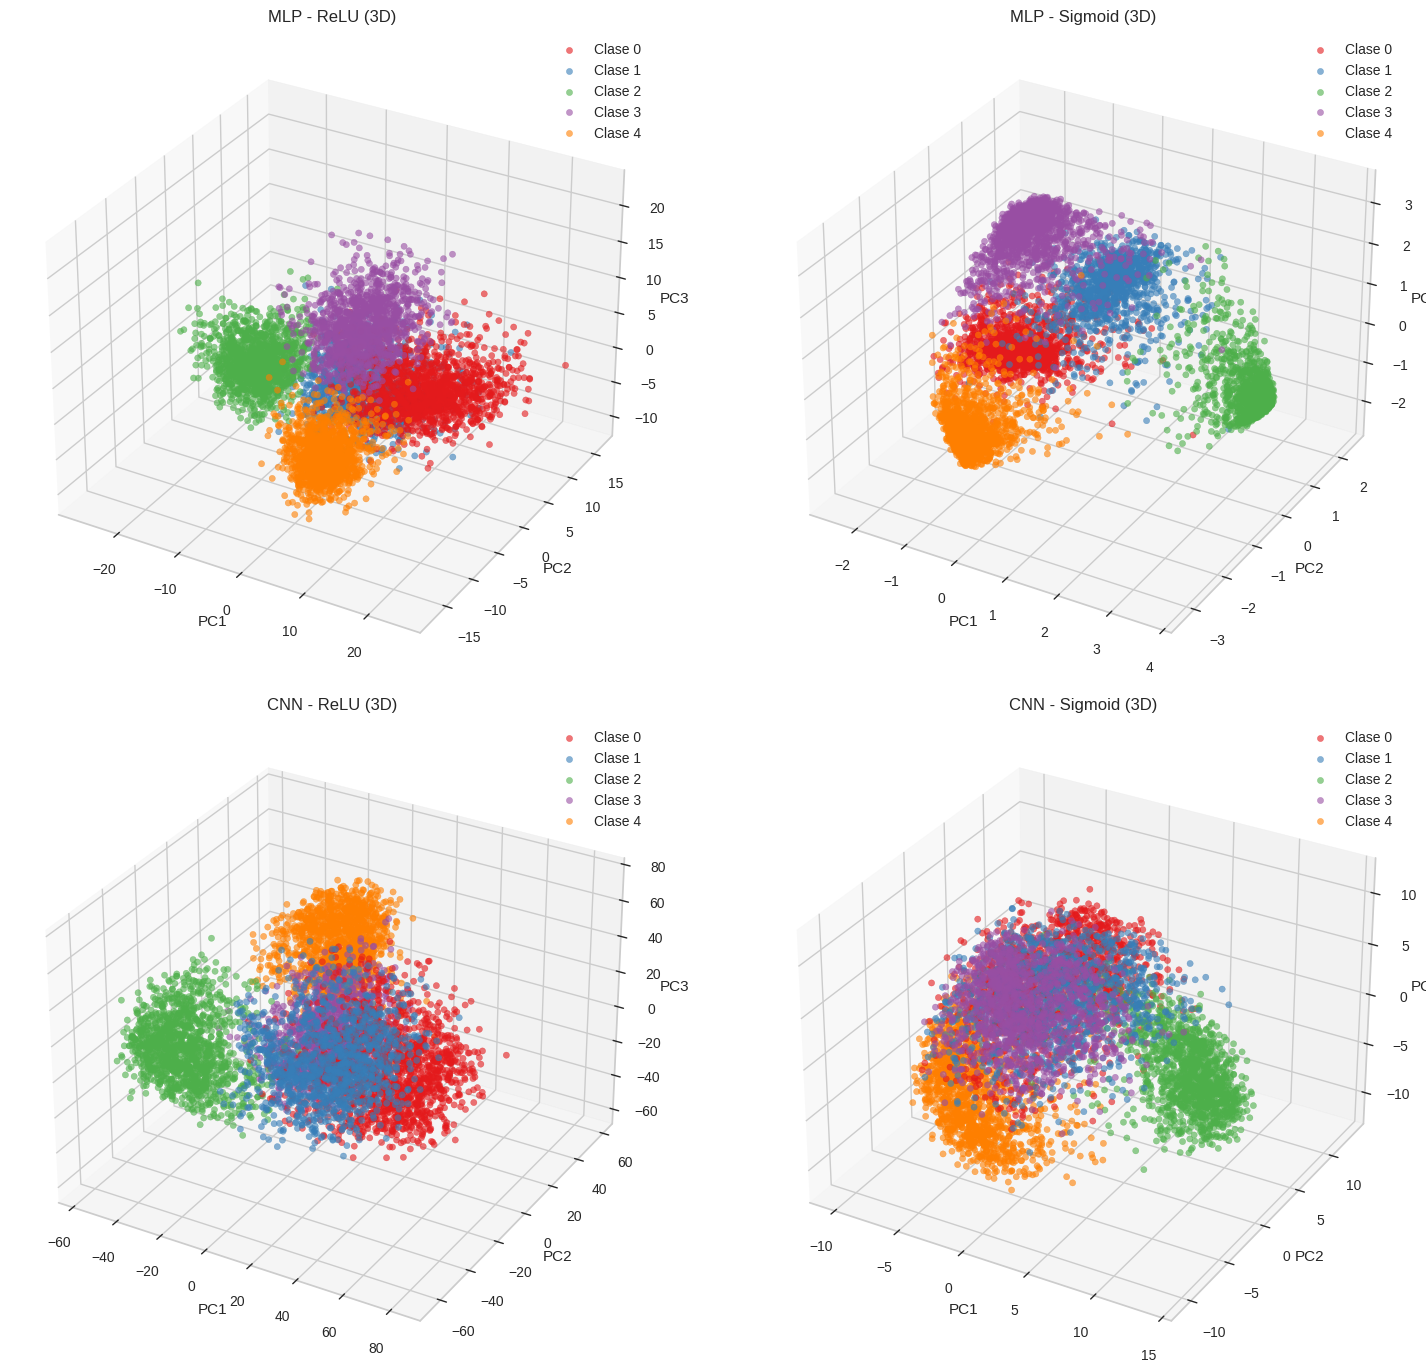

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure(figsize=(16, 14))

# Definir una paleta de colores más distintiva
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']  # rojo, azul, verde, morado, naranja

# MLP ReLU
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_mlp_relu)
for i in range(5):
    mask = labels_mlp_relu == i
    ax1.scatter(features_pca[mask, 0], features_pca[mask, 1], features_pca[mask, 2],
               c=colors[i], label=f'Clase {i}', s=20, alpha=0.6)
ax1.set_title('MLP - ReLU (3D)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend()

# MLP Sigmoid
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_mlp_sigmoid)
for i in range(5):
    mask = labels_mlp_sigmoid == i
    ax2.scatter(features_pca[mask, 0], features_pca[mask, 1], features_pca[mask, 2],
               c=colors[i], label=f'Clase {i}', s=20, alpha=0.6)
ax2.set_title('MLP - Sigmoid (3D)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()

# CNN ReLU
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_cnn_relu)
for i in range(5):
    mask = labels_cnn_relu == i
    ax3.scatter(features_pca[mask, 0], features_pca[mask, 1], features_pca[mask, 2],
               c=colors[i], label=f'Clase {i}', s=20, alpha=0.6)
ax3.set_title('CNN - ReLU (3D)')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.legend()

# CNN Sigmoid
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_cnn_sigmoid)
for i in range(5):
    mask = labels_cnn_sigmoid == i
    ax4.scatter(features_pca[mask, 0], features_pca[mask, 1], features_pca[mask, 2],
               c=colors[i], label=f'Clase {i}', s=20, alpha=0.6)
ax4.set_title('CNN - Sigmoid (3D)')
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
ax4.set_zlabel('PC3')
ax4.legend()

plt.tight_layout()
plt.show()

Visualizando el PCA en 2D y 3D de las características extraídas por las diferentes arquitecturas de redes neuronales, podemos observar cómo cada modelo organiza las clases en el espacio de características. Con la tercera dimensión añadida, la separación entre las clases se vuelve aún más evidente, especialmente en el caso de la red MLP. Mientras que en las redes convolucionales las clases siguen sin estar muy separadas.

Text(0.5, 1.0, 'MLP - ReLU')

Text(0.5, 0, 'Componente principal')

Text(0, 0.5, 'Ratio de varianza')

(1.0, 50.0)

Text(0.5, 1.0, 'MLP - Sigmoid')

Text(0.5, 0, 'Componente principal')

Text(0, 0.5, 'Ratio de varianza')

(1.0, 50.0)

Text(0.5, 1.0, 'CNN - ReLU')

Text(0.5, 0, 'Componente principal')

Text(0, 0.5, 'Ratio de varianza')

(1.0, 50.0)

Text(0.5, 1.0, 'CNN - Sigmoid')

Text(0.5, 0, 'Componente principal')

Text(0, 0.5, 'Ratio de varianza')

(1.0, 50.0)

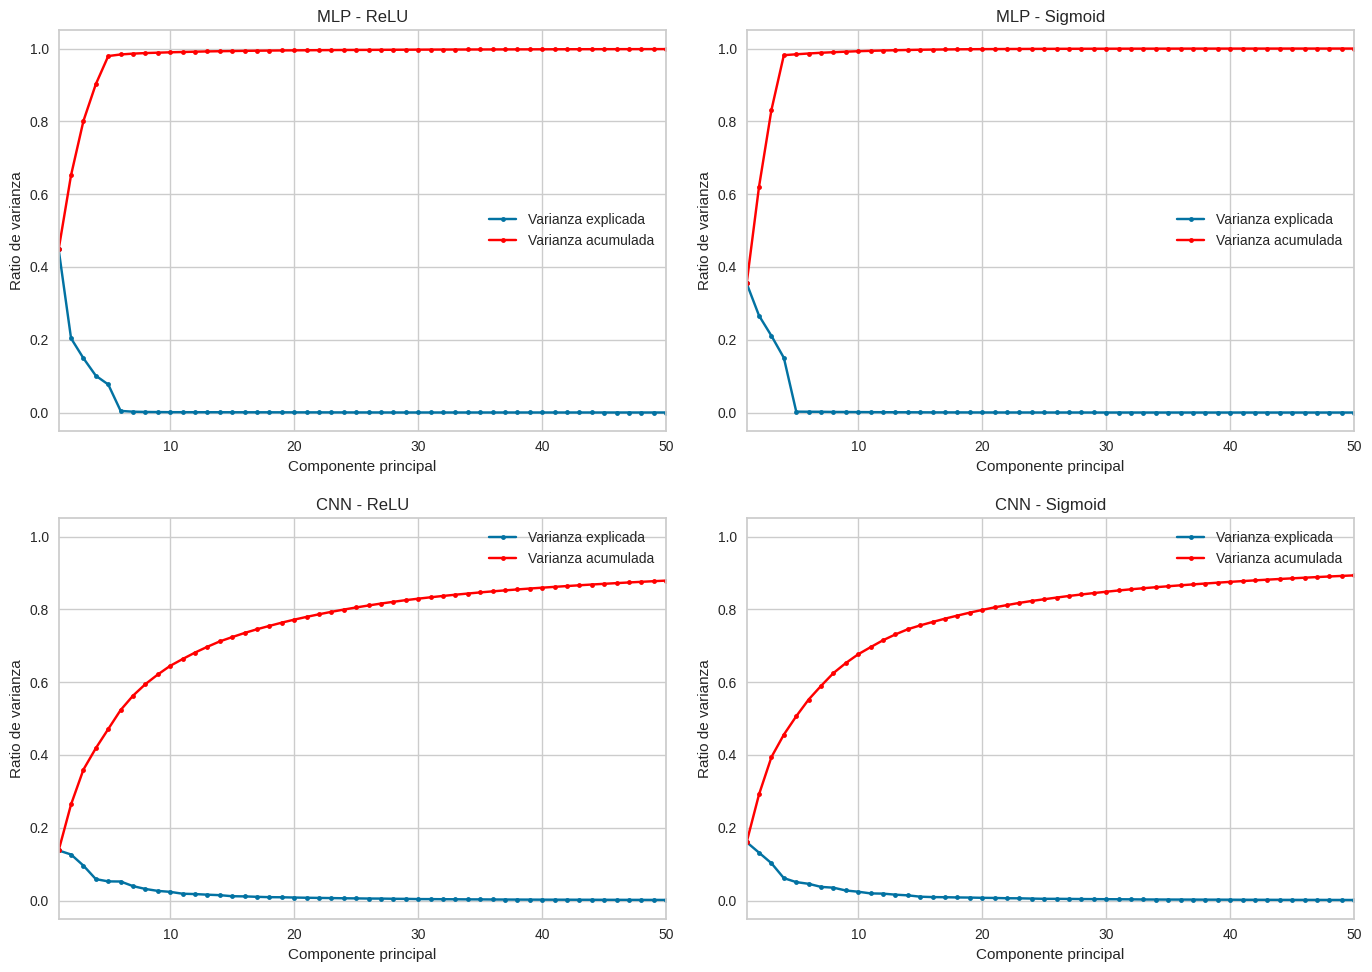

MLP - ReLU: 4 componentes para alcanzar >= 90% de varianza (total comps=128)
MLP - Sigmoid: 4 componentes para alcanzar >= 90% de varianza (total comps=64)
CNN - ReLU: 67 componentes para alcanzar >= 90% de varianza (total comps=6587)
CNN - Sigmoid: 55 componentes para alcanzar >= 90% de varianza (total comps=3136)


In [33]:
# Mostrar varianza explicada y acumulada para las representaciones intermedias
from sklearn.decomposition import PCA

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sets = [
    (features_mlp_relu, 'MLP - ReLU', axes[0, 0]),
    (features_mlp_sigmoid, 'MLP - Sigmoid', axes[0, 1]),
    (features_cnn_relu, 'CNN - ReLU', axes[1, 0]),
    (features_cnn_sigmoid, 'CNN - Sigmoid', axes[1, 1])
]

for feats, name, ax in sets:
    # Ajustar PCA con todos los componentes posibles
    pca_full = PCA().fit(feats)
    evr = pca_full.explained_variance_ratio_
    cum = np.cumsum(evr)

    ax.plot(range(1, len(evr) + 1), evr, marker='.', label='Varianza explicada')
    ax.plot(range(1, len(evr) + 1), cum, c='red', marker='.', label='Varianza acumulada')
    ax.set_title(name)
    ax.set_xlabel('Componente principal')
    ax.set_ylabel('Ratio de varianza')
    ax.set_xlim(1, min(50, len(evr)))
    ax.legend()

plt.tight_layout()
plt.show();

# Opcional: imprimir número de componentes para alcanzar 90% de varianza
for feats, name, _ in sets:
    pca_full = PCA().fit(feats)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    n90 = np.searchsorted(cum, 0.90) + 1
    print(f"{name}: {n90} componentes para alcanzar >= 90% de varianza (total comps={len(cum)})")

Viendo estos graficos podemos entender por que el PCA en 2 dimensiones de los MLP se ven mejor que los del CNN ya que explican más del 60% de varianza mientras que los del CNN no superan el 30%. Y se ve que en las MLP hay muchas componentes que no aportan casi nada de varianza mientras que en las CNN se ve que todas aportan un valor más equivalente. Es decir en CNN la varianza esta mucho más repartida.

Aqui se ve que la hipotesi de que se separa mejor en las MLP que en las CNN es cierta en nuestro caso ya que vemos como para MLP se necesitan muchas menos componentes de PCA para explicar una varianza mayor al 90%.